In [1]:
!pip install gensim==4.3.3
!pip install matplotlib
!pip install scikit-learn

In [4]:

!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz


--2024-09-23 18:45:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.91, 18.165.83.44, 18.165.83.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   141MB/s    in 11s     

2024-09-23 18:45:16 (116 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2024-09-23 18:45:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.91, 18.165.83.44, 18.165.83.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118942272 (1.0G) [binary/octet-stream]
Saving to: ‘cc.hi.300

In [5]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

# English embeddings
en_embeddings = KeyedVectors.load_word2vec_format('cc.en.300.vec.gz', binary=False)

# Hindi embeddings
hi_embeddings = KeyedVectors.load_word2vec_format('cc.hi.300.vec.gz', binary=False)


In [6]:

!wget -c https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt

!wget -c https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt

--2024-09-23 19:00:55--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.53, 13.226.34.83, 13.226.34.7, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219327 (214K) [text/x-c++]
Saving to: ‘en-hi.0-5000.txt’

en-hi.0-5000.txt    100%[===================>] 214.19K  --.-KB/s    in 0.03s   

2024-09-23 19:00:55 (6.68 MB/s) - ‘en-hi.0-5000.txt’ saved [219327/219327]

--2024-09-23 19:00:55--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.53, 13.226.34.83, 13.226.34.7, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52464 (51K) [text/plain]
Saving to: ‘en-hi.5000-6500.txt’

en-hi.5000-6500.txt 100%[

In [7]:


# For English
en_embeddings.vectors = en_embeddings.vectors[:100000]
en_embeddings.index_to_key = en_embeddings.index_to_key[:100000]
en_embeddings.key_to_index = {word: idx for idx, word in enumerate(en_embeddings.index_to_key)}

# For Hindi
hi_embeddings.vectors = hi_embeddings.vectors[:100000]
hi_embeddings.index_to_key = hi_embeddings.index_to_key[:100000]
hi_embeddings.key_to_index = {word: idx for idx, word in enumerate(hi_embeddings.index_to_key)}


In [8]:
# Loading the bilingual lexicon
def load_bilingual_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        bilingual_dict = [line.strip().split() for line in f]
    return bilingual_dict

# Loading training dictionary
train_dict = load_bilingual_lexicon('en-hi.0-5000.txt')


In [9]:
import numpy as np

# source and target matrices
def create_embedding_matrices(bilingual_dict, source_embeddings, target_embeddings):
    source_matrix = []
    target_matrix = []
    oov_count = 0
    for src_word, tgt_word in bilingual_dict:
        if src_word in source_embeddings.key_to_index and tgt_word in target_embeddings.key_to_index:
            source_matrix.append(source_embeddings[src_word])
            target_matrix.append(target_embeddings[tgt_word])
        else:
            oov_count += 1
    print(f'OOV pairs: {oov_count}')
    return np.array(source_matrix), np.array(target_matrix)

# Creating matrices
X_train, Y_train = create_embedding_matrices(train_dict, en_embeddings, hi_embeddings)

# Computing the optimal orthogonal mapping W
def compute_procrustes(X, Y):
    # covariance matrix
    M = Y.T @ X
    # Singular Value Decomposition
    U, _, Vt = np.linalg.svd(M)
    #  orthogonal matrix W
    W = U @ Vt
    return W

# Compute mapping
W = compute_procrustes(X_train, Y_train)


OOV pairs: 574


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Mapping English embeddings to Hindi space
def map_embeddings(embeddings, W):
    mapped_embeddings = embeddings @ W.T
    return mapped_embeddings

# Map the English embeddings
en_mapped_embeddings = map_embeddings(en_embeddings.vectors, W)

# Create a new KeyedVectors instance for mapped English embeddings
en_mapped = KeyedVectors(vector_size=300)
en_mapped.add_vectors(en_embeddings.index_to_key, en_mapped_embeddings)



In [11]:
# Loading the  test dictionary
test_dict = load_bilingual_lexicon('en-hi.5000-6500.txt')


In [12]:
def precision_at_k(source_embeddings, target_embeddings, test_dict, k=1):
    correct = 0
    total = 0
    for src_word, tgt_word in test_dict:
        if src_word in source_embeddings.key_to_index:
            src_vec = source_embeddings[src_word]
            # Computing similarities
            similarities = target_embeddings.cosine_similarities(src_vec, target_embeddings.vectors)
            # Get top k indices
            top_k_indices = np.argsort(-similarities)[:k]
            top_k_words = [target_embeddings.index_to_key[i] for i in top_k_indices]
            if tgt_word in top_k_words:
                correct += 1
            total += 1
    precision = correct / total
    return precision

# Compute P@1 and P@5
p_at_1 = precision_at_k(en_mapped, hi_embeddings, test_dict, k=1)
p_at_5 = precision_at_k(en_mapped, hi_embeddings, test_dict, k=5)

print(f'Precision@1: {p_at_1:.4f}')
print(f'Precision@5: {p_at_5:.4f}')


Precision@1: 0.2490
Precision@5: 0.4873


In [13]:
def analyze_cosine_similarities(bilingual_dict, source_embeddings, target_embeddings, W, sample_size=100):
    import random
    sample_pairs = random.sample(bilingual_dict, sample_size)
    similarities = []
    for src_word, tgt_word in sample_pairs:
        if src_word in source_embeddings.key_to_index and tgt_word in target_embeddings.key_to_index:
            src_vec = source_embeddings[src_word] @ W.T
            tgt_vec = target_embeddings[tgt_word]
            cos_sim = cosine_similarity([src_vec], [tgt_vec])[0][0]
            similarities.append((src_word, tgt_word, cos_sim))
    # Sort
    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities

# similarities
similarities = analyze_cosine_similarities(test_dict, en_embeddings, hi_embeddings, W)

# 10 most similar pairs
for src_word, tgt_word, sim in similarities[:10]:
    print(f'{src_word} - {tgt_word}: {sim:.4f}')


rainfall - वर्षा: 0.6208
tourists - पर्यटक: 0.5945
censorship - सेंसरशिप: 0.5618
pregnant - गर्भवती: 0.5601
boyfriend - बॉयफ्रेंड: 0.5505
philosophers - दार्शनिकों: 0.5452
mapping - मानचित्रण: 0.5447
spa - स्पा: 0.5388
mandatory - अनिवार्य: 0.5263
backup - बैकअप: 0.5251


In [14]:
training_sizes = [5000, 10000, 20000]  # Adjust based on available data


In [15]:
results = []

for size in training_sizes:
    # Use the first 'size' word pairs from the training dictionary
    current_train_dict = train_dict[:size]
    # Create embedding matrices
    X_train, Y_train = create_embedding_matrices(current_train_dict, en_embeddings, hi_embeddings)
    # Compute mapping
    W = compute_procrustes(X_train, Y_train)
    # Map English embeddings
    en_mapped_embeddings = map_embeddings(en_embeddings.vectors, W)
    en_mapped = KeyedVectors(vector_size=300)
    en_mapped.add_vectors(en_embeddings.index_to_key, en_mapped_embeddings)
    # Evaluate
    p_at_1 = precision_at_k(en_mapped, hi_embeddings, test_dict, k=1)
    p_at_5 = precision_at_k(en_mapped, hi_embeddings, test_dict, k=5)
    results.append((size, p_at_1, p_at_5))
    print(f'Training Size: {size}, Precision@1: {p_at_1:.4f}, Precision@5: {p_at_5:.4f}')


OOV pairs: 104
Training Size: 5000, Precision@1: 0.2104, Precision@5: 0.4351
OOV pairs: 574
Training Size: 10000, Precision@1: 0.2490, Precision@5: 0.4873
OOV pairs: 574
Training Size: 20000, Precision@1: 0.2490, Precision@5: 0.4873


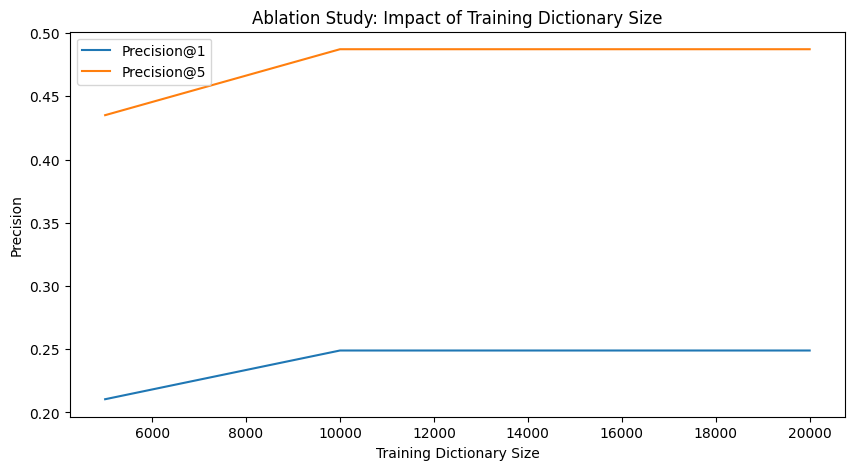

In [16]:
import matplotlib.pyplot as plt

sizes, p1_scores, p5_scores = zip(*results)

plt.figure(figsize=(10, 5))
plt.plot(sizes, p1_scores, label='Precision@1')
plt.plot(sizes, p5_scores, label='Precision@5')
plt.xlabel('Training Dictionary Size')
plt.ylabel('Precision')
plt.title('Ablation Study: Impact of Training Dictionary Size')
plt.legend()
plt.show()


In [17]:
print(test_dict[:5])  # Print the first 5 entries to see the structure

[['variants', 'विसंगतियाँ'], ['baroque', 'बरॉक'], ['iso', 'आईएसओ'], ['integral', 'इंटीग्रल'], ['integral', 'अभिन्न']]


In [18]:
print(train_dict[:5])

[['and', 'और'], ['was', 'था'], ['was', 'थी'], ['for', 'लिये'], ['that', 'उस']]
